<a href="https://colab.research.google.com/github/jcquimpo/GoogleColab_NBs/blob/main/IS392_Proj_1_C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

test = pd.read_csv("testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

train.head(10)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
5,"""8196_8""",1,"""I dont know why people think this is such a b..."
6,"""7166_2""",0,"""This movie could have been very good, but com..."
7,"""10633_1""",0,"""I watched this video at a friend's house. I'm..."
8,"""319_1""",0,"""A friend of mine bought this film for £1, and..."
9,"""8713_10""",1,"""<br /><br />This movie is full of references...."


In [ ]:
train["review"].values[0]
train.shape

(25000, 3)

# Data Spread
* even spread of positive (1) and negative (0)
  - 12500 reviews each

<function matplotlib.pyplot.show(close=None, block=None)>

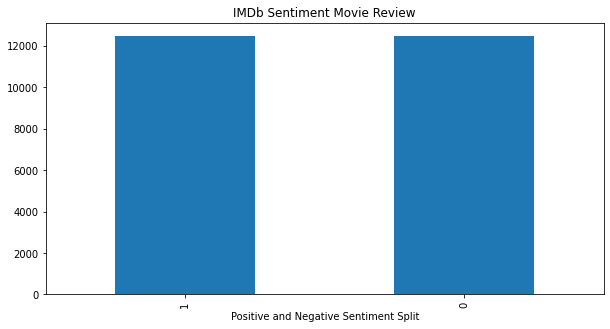

In [ ]:
train['sentiment'].value_counts()
chart = train['sentiment'].value_counts().plot(kind='bar',
                                       title='IMDb Sentiment Movie Review',
                                       figsize=(10, 5))

chart.set_xlabel('Positive and Negative Sentiment Split')
plt.show

In [ ]:
test_txt = train['review'][25]
# print(test_txt)

token_exmp = nltk.word_tokenize(test_txt)

tag_exmp = token_exmp[:10]
nltk.pos_tag(tag_exmp)

[('``', '``'),
 ('looking', 'VBG'),
 ('for', 'IN'),
 ('quo', 'JJ'),
 ('vadis', 'NN'),
 ('at', 'IN'),
 ('my', 'PRP$'),
 ('local', 'JJ'),
 ('video', 'NN'),
 ('store', 'NN')]

## VADER MODEL
* VADER
  - Valence Aware Dictionary and sEntiment Reasoner
  - takes all the words in a sentence and scales them if they are positive or negative and calculates how positive or negative the sentence is
  - it will **not** account for relationship between words

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

sia.polarity_scores(test_txt)

{'neg': 0.109, 'neu': 0.791, 'pos': 0.1, 'compound': -0.5457}

In [ ]:
from tqdm.notebook import tqdm

# going to use this to iterate over the dataset
results = {}

for i, row in tqdm(train.iterrows(), total=len(train)):
  text = row['review']
  id = row['id']
  results[id] = sia.polarity_scores(text)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
# results
vaders = pd.DataFrame(results).T
print(vaders)

             neg    neu    pos  compound
"5814_8"   0.130  0.744  0.126   -0.8278
"2381_9"   0.047  0.739  0.214    0.9819
"7759_3"   0.142  0.800  0.058   -0.9883
"3630_4"   0.066  0.878  0.056   -0.2189
"9495_8"   0.119  0.741  0.140    0.7960
...          ...    ...    ...       ...
"3453_3"   0.026  0.822  0.152    0.8750
"5064_1"   0.086  0.662  0.252    0.9861
"10905_3"  0.055  0.783  0.162    0.9428
"10194_3"  0.136  0.768  0.096   -0.9195
"8478_8"   0.154  0.721  0.125   -0.2489

[25000 rows x 4 columns]


## NOT using VADER Model
* Vader model's results ended with almost eveyrthing being neutral


## Logistic Regression Model

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from bs4 import BeautifulSoup
import string
from sklearn import model_selection, metrics
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* Pre-processing Data


In [ ]:
#Remove Hashtags
train['review'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)
#Remove Mention
train['review'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)
#Remove URL
train['review'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)
train['review']=train['review'].str.lower()

In [ ]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""with all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""the classic war of the worlds\"" by timothy ..."
2,"""7759_3""",0,"""the film starts with a manager (nicholas bell..."
3,"""3630_4""",0,"""it must be assumed that those who praised thi..."
4,"""9495_8""",1,"""superbly trashy and wondrously unpretentious ..."


* Vectorization

  - TF-IDF

In [ ]:
import csv
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
y = train['sentiment']
x = train['review']

In [ ]:
# Creating a word corpus for vectorization
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [ ]:
vectorizer1 = TfidfVectorizer(max_features=1500)
x1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = x1.todense().tolist()
train = pd.DataFrame(denselist1, columns=feature_names1)

In [ ]:
# splitting the training and testing part from the data
X_temp, X_test, y_temp, y_test = train_test_split(train, y, test_size=0.1, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
accuracy = {'TF-IDF':[], 'BoW': []}

In [ ]:
#TF-IDF
# regressor_LR_tf = LogisticRegression(C=1,penalty='l2',solver='liblinear')
regressor_LR_tf = LogisticRegression(C=1,penalty='l2',solver='newton-cg')
regressor_LR_tf.fit(X_temp, y_temp)
y_predict_LR_tf = regressor_LR_tf.predict(X_test)
a=(regressor_LR_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_LR_tf))
print(metrics.classification_report(y_test, y_predict_LR_tf))
print(metrics.accuracy_score(y_test, y_predict_LR_tf))

[[1105  178]
 [ 136 1081]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1283
           1       0.86      0.89      0.87      1217

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500

0.8744


In [ ]:
# import csv

# results = pd.DataFrame({'id': train['id'], 'sentiment': y_predict_LR_tf})
# print(results)

# results.to_csv('/kaggle/working/submission.csv', index=False)
# print(y_predict_LR_tf)